# Descriptive stats for datasets and network localization

-------------------

Author: Brin Rosenthal (sbrosenthal@ucsd.edu)

-------------------

<a id='toc'></a>
# Table of Contents
1. [Import packages](#import)
2. [Load gene sets](#load_genes)
3. [Load background interactomes](#load_interactomes)
4. [Select focal interactome](#select_focal_interactome)
5. [Two disease localization methods](#disease_localization)





<a id='import'></a>
## Import packages

In [2]:
# import matplotlib
# matplotlib.use('TkAgg')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

import community

from scipy.stats import mannwhitneyu

import mygene
mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

sns.set_style('white')

import sys
#sys.path.append('barabasi_incomplete_interactome/source/')

sys.path.append('../../code/')
import load_interactomes


import visJS2jupyter.visJS_module
import visJS2jupyter.visualizations



% matplotlib inline

In [3]:
nx.__version__

'1.11'

In [4]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [5]:
# also import network_utilities, for degree and topology preserving node permutation method
# from https://github.com/emreg00/toolbox
import network_utilities

GenRev not found, steiner wont work


In [6]:
# import network_bio_toolkit for localization methods

sys.path.append('/Users/brin/network_bio_toolkit/network_bio_toolkit')

import Heat2

# Some gene symbols in the data were not consistent with networks -- load mapping

In [7]:
map_old_new = pd.read_csv('../../data/ASD_EPI_CHD_HC_and_DNVs_symbol_gene_description.txt',sep='\t')
map_old_new.index=map_old_new['original_symbol']
map_old_new = map_old_new['symbol']
map_old_new.head()

original_symbol
A2M          A2M
A2ML1      A2ML1
AASS        AASS
ABCA1      ABCA1
ABCA13    ABCA13
Name: symbol, dtype: object

[TOC](#toc)

<a id='load_genes'></a>
# Load the data- including ASD, EPI and CHD

ASD, CHD, EPI gene lists (suggested by Jeremy)

ASD genes come from table 4 in http://www.cell.com/neuron/fulltext/S0896-6273(15)00773-4 

In [15]:
# ------- ASD HC genes -------

ASD_HC = pd.read_csv('../../data/ASD_HC.txt',names=['HC_genes'])

ASD_HC = ASD_HC['HC_genes'].tolist()
len(ASD_HC)




65

In [22]:
# ------- High confidence EPI genes -------

# -----------------------------------------------------------------------------------------
# EPI genes from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3773011/ (329 DNMs- Table S2)

# EPI_HC_df = pd.read_excel('../data/EPI_from_jeremy/table_S2.xlsx')
# EPI_HC_df = EPI_HC_df.dropna()
# EPI_HC = list(EPI_HC_df['Gene'])
# len(EPI_HC)

# -----------------------------------------------------------------------------------------
# Other paper referenced by Jeremy -- with recurrent mutations http://www.sciencedirect.com/science/article/pii/S0002929714003838


EPI_HC = pd.read_csv('../../data/EPI_HC.txt',names=['HC_genes'])

EPI_HC = EPI_HC['HC_genes'].tolist()
len(EPI_HC)


# -----------------------------------------------------------------------------------------

18

In [24]:
# ------- High confidence CHD genes -------

# Load congenital heart defect recurring DNVs (from http://science.sciencemag.org/content/sci/350/6265/1262.full.pdf)

CHD_HC = pd.read_csv('../../data/CHD_HC.txt',names=['HC_genes'])

CHD_HC = CHD_HC['HC_genes'].tolist()
len(CHD_HC)



21

In [137]:
# ------- Full set of EPI DNVs -------

# Load DNVs from Epilepsy paper (http://www.sciencedirect.com/science/article/pii/S0002929714003838)
EPI_full_DNV = pd.read_excel('../../data/EPI_from_jeremy/1-s2.0-S0002929714003838-mmc2.xlsx')
print(len(EPI_full_DNV))
EPI_full_DNV = EPI_full_DNV[EPI_full_DNV['Variant effect'] != 'synonymous'] # get rid of synonymous DNVs
print(len(EPI_full_DNV))

EPI_full_DNV = EPI_full_DNV['Gene'].tolist()

# parse the parenthese
EPI_full_temp = []
for g in EPI_full_DNV:
    if type(g)==unicode:
        gtemp = g.split(' ')
        gtemp = [x.replace('(','').replace(')','') for x in gtemp]

        EPI_full_temp.extend(gtemp)
    
        
print(len(EPI_full_temp))

EPI_full_DNV = EPI_full_temp
EPI_full_DNV[0:10]

433
345
343


[u'KCNB1',
 u'GCM2',
 u'NFE2L1',
 u'PRR19',
 u'KMT2B',
 u'MLL4',
 u'HSF2',
 u'CASP9',
 u'PSD3',
 u'SYNE2']

unicode

In [17]:
# Load all NDD DNVs (from CHD paper)
NND_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S08.xlsx',skiprows=1)
ASD_DNV = NND_df[NND_df['Study']=='SSC']
ASD_DNV_VC = ASD_DNV['Gene'].value_counts() # count recurrences
ASD_DNV = list(np.unique(ASD_DNV['Gene'].tolist()))
print(len(ASD_DNV))
print(len(map_old_new.loc[ASD_DNV].dropna()))
ASD_DNV = map_old_new.loc[ASD_DNV].tolist()


EPI_DNV = NND_df[NND_df['Study']=='epi']
EPI_DNV_VC = EPI_DNV['Gene'].value_counts() # count recurrences
EPI_DNV = list(np.unique(EPI_DNV['Gene'].tolist()))
print(len(EPI_DNV))
print(len(map_old_new.loc[EPI_DNV].dropna()))
EPI_DNV = map_old_new.loc[EPI_DNV].tolist()

print(ASD_DNV[0:10])
print(EPI_DNV[0:10])
NND_df.head()


663
663
124
124
['A2ML1', 'AASS', 'ABCA1', 'ABCA13', 'ABCA7', 'ABCB9', 'ABCG1', 'ABI2', 'ABL1', 'ABL2']
['A2M', 'AKR1C4', 'ALG13', 'ANK3', 'ANKRD12', 'ANKRD50', 'AP3S2', 'ARFGEF1', 'ASXL1', 'ATP2B4']


,Study,CHR,POS,REF,ALT,Proband ID,Class,Class (2),Gene,Ensembl Gene ID,AA1,AA2,dbNSFP Meta-SVM Rankscore
0,ASC,1,897739,T,C,09C87513,missense,D-mis,KLHL17,ENSG00000187961,L,P,0.87685
1,SSC,1,1222518,C,A,11563.p1,nonsense,lof,SCNN1D,ENSG00000162572,NaN,NaN,NaN
2,ASC,1,2234766,C,T,08C78919,nonsense,lof,SKI,ENSG00000157933,NaN,NaN,NaN
3,SSC,1,3519049,AC,A,14075.p1,frameshift,lof,MEGF6,ENSG00000162591,NaN,NaN,NaN
4,SSC,1,11205057,T,C,11104.p1,missense,D-mis,MTOR,ENSG00000198793,M,V,0.83852


In [18]:
print(sum(ASD_DNV_VC>1)) # number recurrent ASD
print(sum(EPI_DNV_VC>1)) # number recurrent EPI

63
11


In [22]:
# ------- All CHD DNVs -------

# Load all CHD DNVs (from Database S2 in http://science.sciencemag.org/content/sci/350/6265/1262.full.pdf)
CHD_DNV_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S02.xlsx',skiprows=1)
# exclude synonymous and non-damaging missense
CHD_DNV = CHD_DNV_df[(CHD_DNV_df['Variant Class']!='Synonymous')*(CHD_DNV_df['Variant Class']!='Missense')] 
#CHD_DNV = CHD_DNV_df[(CHD_DNV_df['Variant Class']!='Synonymous')] 
CHD_DNV_VC = CHD_DNV['Gene'].value_counts() # count recurrences
#CHD_DNV = CHD_DNV_df
CHD_DNV = list(np.unique(CHD_DNV['Gene'].tolist()))
CHD_DNV_df.index=CHD_DNV_df['Blinded ID']
print(len(CHD_DNV))
print(len(map_old_new.loc[CHD_DNV].dropna()))
CHD_DNV = map_old_new.loc[CHD_DNV].tolist()
CHD_DNV_df.head()

332
332


/Users/brin/anaconda/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


,Blinded ID,CHROM,POS,REF,ALT,Gene,Ensembl Gene ID,Variant Class,AA Change,dbNSFP Meta-SVM Rankscore,Comments
Blinded ID,,,,,,,,,,,
1-01916,1-01916,1,1226468,TCG,AAA,SCNN1D,ENSG00000162572,Missense/Missense,I503K;V504I,NA*;0.51560,*multinucleotide mutation produces AA change n...
GT04013292,GT04013292,20,46279769,GA,TT,NCOA3,ENSG00000124151,Missense,E1158L,NA*,*multinucleotide mutation produces AA change n...
1-00070,1-00070,18,24496529,A,G,CHST9,ENSG00000154080,Synonymous,NaN,NaN,NaN
1-00075,1-00075,1,114354867,C,A,RSBN1,ENSG00000081019,Synonymous,NaN,NaN,NaN
1-00075,1-00075,9,104302602,C,T,RNF20,ENSG00000155827,Nonsense,NaN,NaN,NaN


In [23]:
print(sum(CHD_DNV_VC>1)) # number recurrent CHD

21


In [24]:
# ---------- Load phenotype data for CHD cohort (from Database S1) ----------
CHD_pheno_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S01.xlsx',skiprows=2)
CHD_pheno_df.index=CHD_pheno_df['Blinded ID']


p_withNDD = CHD_pheno_df[CHD_pheno_df['NDD']=='Yes'].index.tolist()
print(len(p_withNDD))
p_noNDD = CHD_pheno_df[CHD_pheno_df['NDD']=='No'].index.tolist()
print(len(p_noNDD))


DNV_withNDD = CHD_DNV_df.loc[p_withNDD]
#DNV_withNDD = DNV_withNDD['Gene']
# only keep likely damaging variants
DNV_withNDD = DNV_withNDD[(DNV_withNDD['Variant Class']!='Synonymous')*(DNV_withNDD['Variant Class']!='Missense')]['Gene']
#DNV_withNDD = DNV_withNDD[(DNV_withNDD['Variant Class']!='Synonymous')]['Gene']
DNV_withNDD = DNV_withNDD.dropna() # drop patients with no DNVs
DNV_withNDD = DNV_withNDD.unique().tolist()
print(len(DNV_withNDD))
print(len(map_old_new.loc[DNV_withNDD].dropna()))
DNV_withNDD = map_old_new.loc[DNV_withNDD].tolist()

DNV_noNDD = CHD_DNV_df.loc[p_noNDD]
#DNV_noNDD = DNV_noNDD['Gene']
# only keep likely damaging variants
DNV_noNDD = DNV_noNDD[(DNV_noNDD['Variant Class']!='Synonymous')*(DNV_noNDD['Variant Class']!='Missense')]['Gene']
#DNV_noNDD = DNV_noNDD[(DNV_noNDD['Variant Class']!='Synonymous')]['Gene']
DNV_noNDD = DNV_noNDD.dropna() # drop patients with no DNVs
DNV_noNDD = DNV_noNDD.unique().tolist()
print(len(DNV_noNDD))
print(len(map_old_new.loc[DNV_noNDD].dropna()))
DNV_noNDD = map_old_new.loc[DNV_noNDD].tolist()


CHD_pheno_df.head()

413
438
137
137
104
104


,Blinded ID,Cohort,Cardiac Category,Cardiac Diagnoses,NDD,Developmental Delay,Learning Disability,Mental Retardation,Autism Spectrum,PDI or MDI score < 70,At risk score in ASQ,Extra-cardiac CA,Extra-Cardiac CA Phenotypes
Blinded ID,,,,,,,,,,,,,
1-00018,1-00018,PCGC,LVO,AORTIC STENOSIS;BICOMMISSURAL AORTIC VALVE;COA...,Yes,No,Yes,No,No,NaN,NaN,Yes,Acute Nephritis;Phimosis
1-00025,1-00025,PCGC,HTX,"AORTIC ARCH HYPOPLASIA;ATRIAL SEPTAL DEFECT, S...",Yes,Yes,No,No,No,NaN,NaN,No,None
1-00041,1-00041,PCGC,CTD,BICOMMISSURAL AORTIC VALVE;TETRALOGY OF FALLOT...,No,No,No,No,No,NaN,NaN,No,None
1-00046,1-00046,PCGC,CTD,HYPOPLASTIC PULMONARY ANNULUS;PULMONARY STENOS...,No,No,No,No,No,NaN,NaN,No,None
1-00047,1-00047,PCGC,LVO,AORTIC STENOSIS - SUPRAVALVAR;BICOMMISSURAL AO...,Yes,No,Yes,No,No,NaN,NaN,No,None


In [25]:
# Load control DNVs (from Database S3)
ctrl_DNV_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S03.xlsx',skiprows=1)

# exclude synonymouse and non-damaging missense
ctrl_DNV = ctrl_DNV_df[(ctrl_DNV_df['Variant Class']!='Synonymous')*(ctrl_DNV_df['Variant Class']!='Missense')]
#ctrl_DNV = ctrl_DNV_df
ctrl_DNV = list(np.unique(ctrl_DNV['Gene'].tolist()))
print(len(ctrl_DNV))
ctrl_DNV_df.head()

193


,Blinded ID,CHROM,POS,REF,ALT,Gene,Ensembl Gene ID,Variant Class,AA Change,dbNSFP Meta-SVM Rankscore,Comments
0,11003.s1,1,202715044,G,C,KDM5B,ENSG00000117139,Nonsense,NaN,NaN,NaN
1,11003.s1,5,178139609,G,A,ZNF354A,ENSG00000169131,Nonsense,NaN,NaN,NaN
2,11003.s1,16,70819649,C,A,VAC14,ENSG00000103043,Missense,A127S,0.08066,NaN
3,11003.s1,X,48374469,C,T,PORCN,ENSG00000102312,Missense,R288W,0.65878,NaN
4,11008.s1,12,94769688,G,A,CCDC41,ENSG00000173588,Nonsense,NaN,NaN,NaN


In [19]:
# CHD associated genes in OMIM (includes aliases)
# CHD_omim = ['PRKD1','PRKCM','PKD','CHDED','ABL1','CHDSKM','CDK13','CDC2L5','CHED','CHDFIDD','CHDT3','NR2F2',
#            'TFCOUP2','ARP1','CHTD4','ZIC3','HTX1','HTX','VACTERLX','DTNA', 'D18S892E', 'DRP3', 'LVNC1',
#            'B3GAT3', 'GLCATI', 'JDSCD','GATA6', 'AVSD5', 'ASD9', 'AVSD5', 'PACHD','TKT', 'SDDHD','WDPCP', 
#             'C2orf86', 'BBS15', 'CHDTHP','JAG1', 'AGS1', 'AHD']
#np.intersect1d(CHD_omim,Gint.nodes())

# Find the SSC DNVs from probands which also have seizures

In [26]:
# Load the SSC phenotype data
SSC_pheno_df = pd.read_csv('/Users/brin/Documents/CCBB_tickets_data/SFARI/SSC_phenotype/SSC_Version_15_Phenotype_Data_Set/Proband_Data/ssc_core_descriptive.csv',
                          sep=',',index_col='individual')
SSC_pheno_df.head()



,measure,abc_total_score,adi_r_b_comm_verbal_total,adi_r_comm_b_non_verbal_total,adi_r_cpea_dx,adi_r_evidence_onset,adi_r_rrb_c_total,adi_r_soc_a_total,ados_communication_social,ados_css,...,srs_teacher_t_score,ssc_diagnosis_full_scale_iq,ssc_diagnosis_full_scale_iq_type,ssc_diagnosis_nonverbal_iq,ssc_diagnosis_nonverbal_iq_type,ssc_diagnosis_nvma,ssc_diagnosis_verbal_iq,ssc_diagnosis_verbal_iq_type,ssc_diagnosis_vma,vineland_ii_composite_standard_score
individual,,,,,,,,,,,,,,,,,,,,,
11000.p1,(11000.p1).ssc-summary-variables.1,47.0,24.0,13.0,1-autism,yes,6.0,24.0,10.0,6,...,NaN,65.0,2.0,78.0,1.0,79.0,50.0,2.0,55.0,74.0
11001.p1,(11001.p1).ssc-summary-variables.1,15.0,19.0,9.0,1-autism,yes,4.0,17.0,11.0,7,...,NaN,124.0,1.0,123.0,1.0,131.0,113.0,1.0,113.0,77.0
11002.p1,(11002.p1).ssc-summary-variables.1,14.0,21.0,12.0,1-autism,yes,8.0,27.0,14.0,9,...,NaN,100.0,1.0,111.0,1.0,106.0,80.0,1.0,68.0,80.0
11003.p1,(11003.p1).ssc-summary-variables.1,65.0,20.0,12.0,1-autism,yes,8.0,21.0,10.0,8,...,77.0,109.0,1.0,108.0,1.0,156.0,108.0,1.0,153.0,75.0
11004.p1,(11004.p1).ssc-summary-variables.1,52.0,22.0,11.0,2-asd,yes,10.0,9.0,19.0,10,...,NaN,59.0,1.0,74.0,1.0,117.0,31.0,1.0,72.0,64.0


In [27]:
# Locate the probands with any type of epilepsy
epi_columns = ['febrile_seizures','non_febrile_seizures']

SSC_with_epi = SSC_pheno_df[epi_columns]>0
SSC_with_epi = SSC_with_epi[SSC_with_epi.sum(axis=1)>0].index.tolist()
len(SSC_with_epi)


326

In [28]:
print(len(SSC_pheno_df.index.unique())) # num in SSC cohort
print(len(np.intersect1d(SSC_with_epi,NND_df['Proband ID'].tolist()))) # num SSC in NDD with epi symptoms
print(len(NND_df[NND_df['Study']=='SSC']['Proband ID'].unique())) # num in SSC cohort
print(len(NND_df[NND_df['Study']=='epi']['Proband ID'].unique())) # num in epi cohort

print(len(CHD_pheno_df['Blinded ID'].unique())) # num in CHD cohort
print(sum(CHD_pheno_df['NDD']=='Yes'))

2759
91
636
121
1213
413


In [29]:
SSC_pheno_df.head()

,measure,abc_total_score,adi_r_b_comm_verbal_total,adi_r_comm_b_non_verbal_total,adi_r_cpea_dx,adi_r_evidence_onset,adi_r_rrb_c_total,adi_r_soc_a_total,ados_communication_social,ados_css,...,srs_teacher_t_score,ssc_diagnosis_full_scale_iq,ssc_diagnosis_full_scale_iq_type,ssc_diagnosis_nonverbal_iq,ssc_diagnosis_nonverbal_iq_type,ssc_diagnosis_nvma,ssc_diagnosis_verbal_iq,ssc_diagnosis_verbal_iq_type,ssc_diagnosis_vma,vineland_ii_composite_standard_score
individual,,,,,,,,,,,,,,,,,,,,,
11000.p1,(11000.p1).ssc-summary-variables.1,47.0,24.0,13.0,1-autism,yes,6.0,24.0,10.0,6,...,NaN,65.0,2.0,78.0,1.0,79.0,50.0,2.0,55.0,74.0
11001.p1,(11001.p1).ssc-summary-variables.1,15.0,19.0,9.0,1-autism,yes,4.0,17.0,11.0,7,...,NaN,124.0,1.0,123.0,1.0,131.0,113.0,1.0,113.0,77.0
11002.p1,(11002.p1).ssc-summary-variables.1,14.0,21.0,12.0,1-autism,yes,8.0,27.0,14.0,9,...,NaN,100.0,1.0,111.0,1.0,106.0,80.0,1.0,68.0,80.0
11003.p1,(11003.p1).ssc-summary-variables.1,65.0,20.0,12.0,1-autism,yes,8.0,21.0,10.0,8,...,77.0,109.0,1.0,108.0,1.0,156.0,108.0,1.0,153.0,75.0
11004.p1,(11004.p1).ssc-summary-variables.1,52.0,22.0,11.0,2-asd,yes,10.0,9.0,19.0,10,...,NaN,59.0,1.0,74.0,1.0,117.0,31.0,1.0,72.0,64.0


In [30]:
# How many overlap with the DNVs from homsy_database_S08? 
print(len(np.intersect1d(SSC_with_epi,NND_df['Proband ID'].tolist())))
NND_df.index = NND_df['Proband ID']

ASD_EPI_DNV = NND_df.loc[SSC_with_epi]['Gene'].dropna()
print(len(ASD_EPI_DNV))


91
111


## Define gene sets for use in rest of analysis

In [33]:
# pick out which gene sets to investigate
genes_ASD = ASD_HC
print(len(genes_ASD))
genes_EPI = EPI_HC
print(len(genes_EPI))
genes_CHD = CHD_HC
print(len(genes_CHD))

65
18
21


# Make figure 1: summary of HC genes in CHD ASD and EPI (showing low recurrence)

Look into circleMap https://github.com/chkw/stuartlab-circleplotter-py

In [34]:
ASD_EPI_df = NND_df[(NND_df['Study']=='SSC') | (NND_df['Study']=='epi')]
ASD_EPI_df.head()

,Study,CHR,POS,REF,ALT,Proband ID,Class,Class (2),Gene,Ensembl Gene ID,AA1,AA2,dbNSFP Meta-SVM Rankscore
Proband ID,,,,,,,,,,,,,
11563.p1,SSC,1,1222518,C,A,11563.p1,nonsense,lof,SCNN1D,ENSG00000162572,NaN,NaN,NaN
14075.p1,SSC,1,3519049,AC,A,14075.p1,frameshift,lof,MEGF6,ENSG00000162591,NaN,NaN,NaN
11104.p1,SSC,1,11205057,T,C,11104.p1,missense,D-mis,MTOR,ENSG00000198793,M,V,0.83852
12340.p1,SSC,1,12175787,G,A,12340.p1,splice,lof,TNFRSF8,ENSG00000120949,NaN,NaN,NaN
13930.p1,SSC,1,12428630,T,C,13930.p1,missense,D-mis,VPS13D,ENSG00000048707,I,T,0.84048


In [35]:
CHD_DNV_df.head()

,Blinded ID,CHROM,POS,REF,ALT,Gene,Ensembl Gene ID,Variant Class,AA Change,dbNSFP Meta-SVM Rankscore,Comments
Blinded ID,,,,,,,,,,,
1-01916,1-01916,1,1226468,TCG,AAA,SCNN1D,ENSG00000162572,Missense/Missense,I503K;V504I,NA*;0.51560,*multinucleotide mutation produces AA change n...
GT04013292,GT04013292,20,46279769,GA,TT,NCOA3,ENSG00000124151,Missense,E1158L,NA*,*multinucleotide mutation produces AA change n...
1-00070,1-00070,18,24496529,A,G,CHST9,ENSG00000154080,Synonymous,NaN,NaN,NaN
1-00075,1-00075,1,114354867,C,A,RSBN1,ENSG00000081019,Synonymous,NaN,NaN,NaN
1-00075,1-00075,9,104302602,C,T,RNF20,ENSG00000155827,Nonsense,NaN,NaN,NaN


In [36]:
# rename CHD_DNV_df columns for merge with ASD_EPI_df
new_columns = ['Proband ID', 'CHR', 'POS', 'REF', 'ALT', 'Gene',
       'Ensembl Gene ID', 'Class', 'AA Change',
       'dbNSFP Meta-SVM Rankscore', 'Comments']
CHD_DNV_for_merge = CHD_DNV_df.copy(deep=True)

# get rid of non-damaging missense and synonymous 
CHD_DNV_for_merge.columns = new_columns
CHD_DNV_for_merge = CHD_DNV_for_merge[(CHD_DNV_for_merge['Class']!='Missense') & (CHD_DNV_for_merge['Class']!='Synonymous')]
CHD_DNV_for_merge['Study']='CHD'
CHD_DNV_for_merge.head()

,Proband ID,CHR,POS,REF,ALT,Gene,Ensembl Gene ID,Class,AA Change,dbNSFP Meta-SVM Rankscore,Comments,Study
Blinded ID,,,,,,,,,,,,
1-01916,1-01916,1,1226468,TCG,AAA,SCNN1D,ENSG00000162572,Missense/Missense,I503K;V504I,NA*;0.51560,*multinucleotide mutation produces AA change n...,CHD
1-00075,1-00075,9,104302602,C,T,RNF20,ENSG00000155827,Nonsense,NaN,NaN,NaN,CHD
1-00114,1-00114,X,100652863,AT,A,GLA,ENSG00000102393,frameshift,NaN,NaN,NaN,CHD
1-00141,1-00141,4,140306112,C,A,NAA15,ENSG00000164134,Nonsense,NaN,NaN,NaN,CHD
1-00141,1-00141,18,19085419,G,A,GREB1L,ENSG00000141449,Nonsense,NaN,NaN,NaN,CHD


In [37]:
columns_to_keep = ['Study','Proband ID', 'CHR', 'POS', 'REF', 'ALT', 'Gene',
       'Ensembl Gene ID', 'Class','dbNSFP Meta-SVM Rankscore']
ASD_EPI_CHD_df = ASD_EPI_df[columns_to_keep].append(CHD_DNV_for_merge[columns_to_keep])
ASD_EPI_CHD_df.head()


,Study,Proband ID,CHR,POS,REF,ALT,Gene,Ensembl Gene ID,Class,dbNSFP Meta-SVM Rankscore
11563.p1,SSC,11563.p1,1,1222518,C,A,SCNN1D,ENSG00000162572,nonsense,NaN
14075.p1,SSC,14075.p1,1,3519049,AC,A,MEGF6,ENSG00000162591,frameshift,NaN
11104.p1,SSC,11104.p1,1,11205057,T,C,MTOR,ENSG00000198793,missense,0.83852
12340.p1,SSC,12340.p1,1,12175787,G,A,TNFRSF8,ENSG00000120949,splice,NaN
13930.p1,SSC,13930.p1,1,12428630,T,C,VPS13D,ENSG00000048707,missense,0.84048


In [38]:
ASD_EPI_CHD_df['Study'].value_counts()

SSC    750
CHD    363
epi    147
Name: Study, dtype: int64

In [39]:
# index by gene name, subset by HC genes, sort by relevant fields
ASD_EPI_CHD_df.index=ASD_EPI_CHD_df['Gene']
# add a column for gene value count
gene_VC = ASD_EPI_CHD_df['Gene'].value_counts()
ASD_EPI_CHD_df['value_count']=0
ASD_EPI_CHD_df['value_count'].loc[gene_VC.index]=gene_VC

# add a column for HC gene
ASD_EPI_CHD_df['is_HC_gene']=0
ASD_EPI_CHD_df['is_HC_gene'].loc[np.intersect1d(ASD_EPI_CHD_df['Gene'].tolist(),ASD_HC)]=1
ASD_EPI_CHD_df['is_HC_gene'].loc[np.intersect1d(ASD_EPI_CHD_df['Gene'].tolist(),EPI_HC)]=1
ASD_EPI_CHD_df['is_HC_gene'].loc[np.intersect1d(ASD_EPI_CHD_df['Gene'].tolist(),CHD_HC)]=1

# add a column for study_int
ASD_EPI_CHD_df['study_int']=0
ASD_EPI_CHD_df.index=ASD_EPI_CHD_df['Study']
ASD_EPI_CHD_df['study_int'].loc['SSC']=0
ASD_EPI_CHD_df['study_int'].loc['CHD']=1
ASD_EPI_CHD_df['study_int'].loc['epi']=2
ASD_EPI_CHD_df.index=ASD_EPI_CHD_df['Gene']


AEC_sorted = ASD_EPI_CHD_df.sort_values(['Study','is_HC_gene','value_count','Gene','Class'],ascending=False)

/Users/brin/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
AEC_sorted.head()

,Study,Proband ID,CHR,POS,REF,ALT,Gene,Ensembl Gene ID,Class,dbNSFP Meta-SVM Rankscore,value_count,is_HC_gene,study_int
Gene,,,,,,,,,,,,,
SCN1A,epi,lgsnd30216iy1,2,166911147,C,T,SCN1A,ENSG00000144285,splice,NaN,8,1,2
SCN1A,epi,lgsnd32727kd1,2,166911147,C,T,SCN1A,ENSG00000144285,splice,NaN,8,1,2
SCN1A,epi,lgsnd24053gj1,2,166870322,G,A,SCN1A,ENSG00000144285,nonsense,NaN,8,1,2
SCN1A,epi,lgsnd28509hr1,2,166848563,C,G,SCN1A,ENSG00000144285,missense,0.83776,8,1,2
SCN1A,epi,lgsnd36798lg1,2,166852575,G,T,SCN1A,ENSG00000144285,missense,0.99221,8,1,2


In [41]:
#map from mutation class to integer
class_VC = AEC_sorted['Class'].value_counts()
class_VC
class_to_int = {'missense':1,'frameshift':2,'D-Missense':1,'nonsense':3,'splice':4,'Nonsense':3,'Splice site':4,
               'startloss':5,'Start lost':5,'Missense/Missense':1,'Stop lost':5}
class_to_int

{'D-Missense': 1,
 'Missense/Missense': 1,
 'Nonsense': 3,
 'Splice site': 4,
 'Start lost': 5,
 'Stop lost': 5,
 'frameshift': 2,
 'missense': 1,
 'nonsense': 3,
 'splice': 4,
 'startloss': 5}

In [42]:
# make a gene by patient matrix
genes_HC = np.intersect1d(ASD_HC+EPI_HC+CHD_HC,AEC_sorted['Gene'].tolist()) # make sure they are in the DF
gene_VC_HC = gene_VC.loc[genes_HC].sort_values(ascending=False)

genes_of_interest = gene_VC_HC.index.tolist()
#genes_of_interest = gene_VC.head(25).index.tolist()
#genes_of_interest = genes_of_interest + list(np.setdiff1d(gene_VC.head(10).index.tolist(),genes_of_interest)) # only add new ones

gene_by_patient = pd.DataFrame(np.nan*np.zeros((len(genes_of_interest),len(AEC_sorted))),index=genes_of_interest)
gene_by_patient.columns=AEC_sorted['Proband ID']

for g in genes_of_interest:
    patients_with_g = AEC_sorted.loc[g]['Proband ID']
    if type(patients_with_g)!=unicode:
        patients_with_g = patients_with_g.tolist()
    else:
        patients_with_g = [patients_with_g]
    AEC_gene_temp = AEC_sorted.loc[g].copy(deep=True)
    if type(AEC_gene_temp) == pd.core.series.Series: # deal with only one gene match 
        AEC_gene_temp = pd.DataFrame(AEC_gene_temp).T
        
    AEC_gene_temp.index=AEC_gene_temp['Proband ID']
    for p in patients_with_g:
        
        gene_by_patient.loc[g][p]=class_to_int[AEC_gene_temp['Class'].loc[p]]
        
        
# sort the df by ASD/CHD/EPI high confidence membership

gbp_ASD = gene_by_patient.copy(deep=True).loc[ASD_HC].dropna(how='all')
gbp_ASD = (gbp_ASD>0).sum(axis=1).sort_values(ascending=False)
gbp_ASD.head()

gbp_CHD = gene_by_patient.copy(deep=True).loc[CHD_HC].dropna(how='all')
gbp_CHD = (gbp_CHD>0).sum(axis=1).sort_values(ascending=False)
gbp_CHD.head()

gbp_EPI = gene_by_patient.copy(deep=True).loc[EPI_HC].dropna(how='all')
gbp_EPI = (gbp_EPI>0).sum(axis=1).sort_values(ascending=False)
gbp_EPI.head()

# now reorder
new_index = pd.Series(gbp_EPI.index.tolist()+gbp_ASD.index.tolist()+gbp_CHD.index.tolist())
new_index = new_index.drop_duplicates()

gene_by_patient = gene_by_patient.loc[new_index.tolist()]
gene_by_patient.head()


Proband ID,lgsnd30216iy1,lgsnd32727kd1,lgsnd24053gj1,lgsnd28509hr1,lgsnd36798lg1,lgsnd24646gp1,lgsnd34816ku1,isnd29900bg1,lgsnd32802kf1,isnd38771ahv1,...,1-00880,1-03171,1-01847,1-04574,1-01428,1-03544,1-00619,1-04547,1-06347,1-02675
SCN1A,4.0,4.0,3.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SCN2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STXBP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHD2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDKL5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
gene_by_patient = gene_by_patient.dropna(axis=1,how='all') # drop patients with no HC DNVs
gene_by_patient = gene_by_patient.T
gene_by_patient = gene_by_patient[~gene_by_patient.index.duplicated(keep='first')]
gene_by_patient = gene_by_patient.T
len(gene_by_patient)

85

In [44]:
# find frac patients which have DNVs in each HC gene
ASD_DNV_df = NND_df[NND_df['Study']=='SSC'].copy(deep=True)
EPI_DNV_df = NND_df[NND_df['Study']=='epi'].copy(deep=True)
EPI_DNV_df.head()


,Study,CHR,POS,REF,ALT,Proband ID,Class,Class (2),Gene,Ensembl Gene ID,AA1,AA2,dbNSFP Meta-SVM Rankscore
Proband ID,,,,,,,,,,,,,
isnd25839z1,epi,1,26448790,A,G,isnd25839z1,missense,D-mis,PDIK1L,ENSG00000175087,M,V,0.96797
lgsnd31959kb1,epi,1,26764708,G,A,lgsnd31959kb1,missense,D-mis,DHDDS,ENSG00000117682,R,H,0.98944
lgsnd33762kq1,epi,1,65852515,G,GA,lgsnd33762kq1,frameshift,lof,DNAJC6,ENSG00000116675,NaN,NaN,NaN
isnd29885bz1,epi,1,118039563,C,T,isnd29885bz1,missense,D-mis,MAN1A2,ENSG00000198162,A,V,0.84165
NLES3,epi,1,151021067,C,A,NLES3,nonsense,lof,C1orf56,ENSG00000143443,NaN,NaN,NaN


In [45]:

ASD_count = (gene_by_patient[list(np.intersect1d(ASD_DNV_df.index.tolist(),gene_by_patient.columns.tolist()))]>0).sum(axis=1)
print(sum(ASD_count))

EPI_count = (gene_by_patient[list(np.intersect1d(EPI_DNV_df.index.tolist(),gene_by_patient.columns.tolist()))]>0).sum(axis=1)
EPI_frac = EPI_count/121.0
print(sum(EPI_count))

CHD_count = (gene_by_patient[list(np.intersect1d(CHD_pheno_df.index.tolist(),gene_by_patient.columns.tolist()))]>0).sum(axis=1)
CHD_frac = CHD_count/1213.0
print(sum(CHD_count))

110
37
60


In [46]:
gene_by_patient.shape

(85, 203)

([], <a list of 0 Text xticklabel objects>)

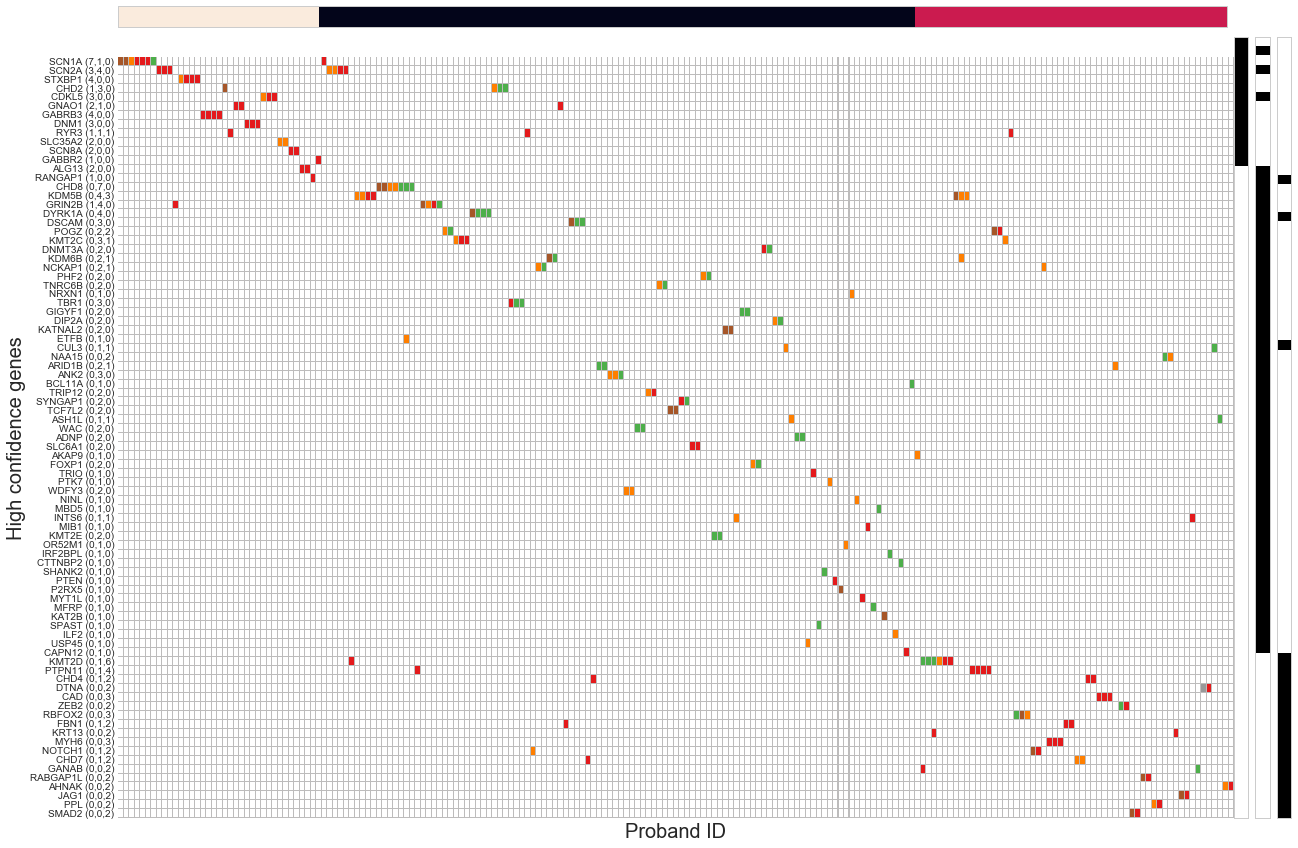

In [47]:
sns.set_style('whitegrid')

plt.figure(figsize=(20,14))
h = sns.heatmap(gene_by_patient,xticklabels=False,cbar=False,cmap='Set1',linewidths=.01,linecolor='#BDBCBC')

plt.sca(h.axes)
plt.xlabel('Proband ID',fontsize=20)
plt.ylabel('High confidence genes',fontsize=20)

yticklabels = [g+' (' + str(int(EPI_count.loc[g]))+','+str(int(ASD_count.loc[g]))+','+str(int(CHD_count.loc[g]))+')' for g in gene_by_patient.index.tolist()]

#tmp = plt.yticks(np.arange(len(gene_by_patient))+.4,gene_by_patient.index.tolist(),fontsize=10)
tmp = plt.yticks(np.arange(len(gene_by_patient))+.4,yticklabels,fontsize=10)

# add bars above fig
AEC_sorted.index = AEC_sorted['Gene']
AEC_temp = AEC_sorted.loc[genes_of_interest].copy(deep=True)
AEC_temp.index=AEC_temp['Proband ID']
temp = AEC_temp['study_int'].loc[gene_by_patient.columns]
temp = temp[~temp.index.duplicated(keep='first')]
temp = np.array(temp.tolist())
temp = temp[np.newaxis,:]
AEC_sorted.index = AEC_sorted['Gene']

h.figure.add_axes([.125,.91,.77,.02]).pcolor(temp)
plt.xlim(0,len(gene_by_patient.columns))
plt.yticks([],'')
plt.xticks([],'')

# add a bar next to fig, for which HC gene set they belong to

#EPI_HC_row
temp_row = pd.Series(np.zeros(len(gene_by_patient)),index=gene_by_patient.index.tolist())
temp_row.loc[np.intersect1d(temp_row.index,EPI_HC)]=1

temp_row = np.array(temp_row.tolist())
temp_row = temp_row[::-1,np.newaxis]
h.figure.add_axes([.9,.125,.01,.775]).pcolor(temp_row,cmap='Greys')
plt.ylim(0,len(gene_by_patient))
plt.yticks([],'')
plt.xticks([],'')

#ASD_HC_row
temp_row = pd.Series(np.zeros(len(gene_by_patient)),index=gene_by_patient.index.tolist())
temp_row.loc[np.intersect1d(temp_row.index,ASD_HC)]=1

temp_row = np.array(temp_row.tolist())
temp_row = temp_row[::-1,np.newaxis]
h.figure.add_axes([.915,.125,.01,.775]).pcolor(temp_row,cmap='Greys')
plt.ylim(0,len(gene_by_patient))
plt.yticks([],'')
plt.xticks([],'')

#CHD_HC_row
temp_row = pd.Series(np.zeros(len(gene_by_patient)),index=gene_by_patient.index.tolist())
temp_row.loc[np.intersect1d(temp_row.index,CHD_HC)]=1

temp_row = np.array(temp_row.tolist())
temp_row = temp_row[::-1,np.newaxis]
h.figure.add_axes([.93,.125,.01,.775]).pcolor(temp_row,cmap='Greys',)
plt.ylim(0,len(gene_by_patient))
plt.yticks([],'')
plt.xticks([],'')





#plt.savefig('../manuscript/figures_17_10/ASD_EPI_CHD_HC_by_mut_type.png',dpi=300,bbox_inches='tight')




In [48]:
gene_by_patient.head()

Proband ID,lgsnd30216iy1,lgsnd32727kd1,lgsnd24053gj1,lgsnd28509hr1,lgsnd36798lg1,lgsnd24646gp1,lgsnd34816ku1,isnd29900bg1,lgsnd32802kf1,isnd38771ahv1,...,1-04363,1-04529,1-00998,1-06769,1-04134,1-02461,1-00577,1-02749,1-02279,1-00658
SCN1A,4.0,4.0,3.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SCN2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STXBP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHD2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDKL5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[TOC](#toc)

<a id='select_focal_interactome'></a>

# Select focal interactome

In [51]:
# load the pre-computed interactome
Gint = nx.read_gpickle('../G_giant_.2.gpickle')
int_name = 'Giant'

In [52]:
print(len(Gint.nodes()))
print(len(Gint.edges()))

14563
1370265


### How much overlap is there between disease genes and selected interactome?




In [53]:
print(len(np.intersect1d(list(ASD_HC),Gint.nodes())))
print(len(ASD_HC))

print(len(np.intersect1d(list(EPI_HC),Gint.nodes())))
print(len(EPI_HC))

print(len(np.intersect1d(list(CHD_HC),Gint.nodes())))
print(len(CHD_HC))

60
65
17
18
20
21


<matplotlib_venn._common.VennDiagram instance at 0x113513368>

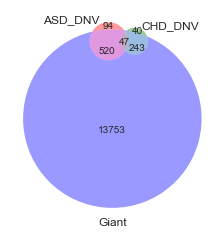

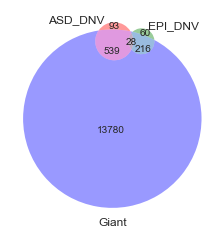

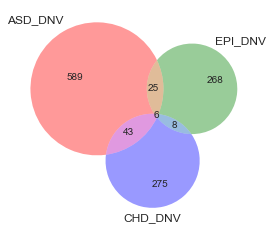

In [54]:
from matplotlib_venn import venn3

venn3([set(ASD_DNV),set(CHD_DNV),set(Gint.nodes())],set_labels=('ASD_DNV','CHD_DNV',int_name))
# plt.savefig('../manuscript/figures_18_02/GIANT_p2/overlap_ASD_CHD_giant_p2.pdf',bbox_inches='tight')
plt.figure()
venn3([set(ASD_DNV),set(EPI_full_DNV),set(Gint.nodes())],set_labels=('ASD_DNV','EPI_DNV',int_name))
# plt.savefig('../manuscript/figures_18_02/GIANT_p2/overlap_ASD_EPI_giant_p2.pdf',bbox_inches='tight')
plt.figure()
venn3([set(ASD_DNV),set(EPI_full_DNV),set(CHD_DNV)],set_labels=('ASD_DNV','EPI_DNV','CHD_DNV'))
# plt.savefig('../manuscript/figures_18_02/GIANT_p2/overlap_ASD_CHD_EPI.pdf',bbox_inches='tight')

[TOC](#toc)

<a id='disease_localization'></a>

# How localized are the individual diseases?

Four localization methods implemented here:

1.  Largest connected component (following Menche et al)
2.  Number shared edges in gene set (similar to method on STRING-DB)


In [64]:
def get_degree_binning(g, bin_size, lengths=None):
    '''
    This function comes from network_utilities.py of emregtoobox.  
    '''
    degree_to_nodes = {}
    for node, degree in g.degree().iteritems():
        if lengths is not None and node not in lengths:
            continue
        degree_to_nodes.setdefault(degree, []).append(node)
    values = degree_to_nodes.keys()
    values.sort()
    bins = []
    i = 0
    while i < len(values):
        low = values[i]
        val = degree_to_nodes[values[i]]
        while len(val) < bin_size:
            i += 1
            if i == len(values):
                break
            val.extend(degree_to_nodes[values[i]])
        if i == len(values):
            i -= 1
        high = values[i]
        i += 1 
        #print low, high, len(val)
        if len(val) < bin_size:
            low_, high_, val_ = bins[-1]
            bins[-1] = (low_, high, val_ + val)
        else:
            bins.append((low, high, val))
    return bins

In [82]:

heat = Heat2.Heat(gene_type = 'symbol', species = 'human')
heat.DG_universe=Gint

## ASD localization

In [165]:
heat.DEG_list = ASD_DNV
heat.DEG_list = list(np.intersect1d(heat.DEG_list,heat.DG_universe.nodes()))
print(len(heat.DEG_list))

567


In [166]:
# set numreps to 1000 for full run

num_reps=1000
ASD_numedges_list, ASD_numedges_rand, ASD_LCC_list, ASD_LCC_size_rand = heat.localization(num_reps = num_reps, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'both', 
                                                                     plot = False)

0.00023412254413279765
Ks_2sampResult(statistic=0.969, pvalue=0.0)


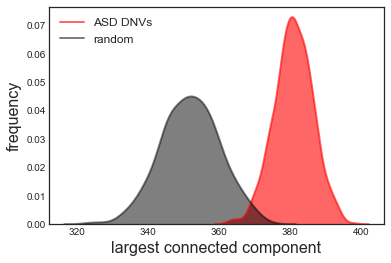

In [167]:
sns.set_style('white')
sns.kdeplot(ASD_LCC_list,color='r',lw=2,alpha=.6,shade=True,label='ASD DNVs')
sns.kdeplot(ASD_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='best',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
ASD_LCC_z = (np.mean(ASD_LCC_list)-np.mean(ASD_LCC_size_rand))/np.std(ASD_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(ASD_LCC_z))

from scipy.stats import ks_2samp
print(ks_2samp(ASD_LCC_list,ASD_LCC_size_rand))

plt.savefig('../../manuscript/figures_18_02/GIANT_p2/ASD_LCC_'+int_name+'_80_bootstrap_N'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

0.0
Ks_2sampResult(statistic=1.0, pvalue=0.0)


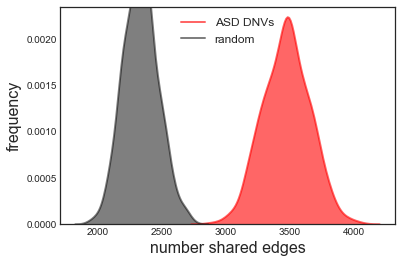

In [168]:
sns.set_style('white')
sns.kdeplot(ASD_numedges_list,color='r',lw=2,alpha=.6,shade=True,label='ASD DNVs')
sns.kdeplot(ASD_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='best',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
ASD_NE_z = (np.mean(ASD_numedges_list)-np.mean(ASD_numedges_rand))/np.std(ASD_numedges_rand)

from scipy.special import ndtr
print(1-ndtr(ASD_NE_z))

from scipy.stats import ks_2samp
print(ks_2samp(ASD_numedges_list,ASD_numedges_rand))

plt.savefig('../../manuscript/figures_18_02/GIANT_p2/ASD_numedges_'+int_name+'_80_bootstrap_N'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

In [169]:
# ----- distributions for non-sampled case -----
# set numreps to 1000 for full run
num_reps=1000
ASD_numedges_list, ASD_numedges_rand, ASD_LCC_list, ASD_LCC_size_rand = heat.localization(num_reps = num_reps, 
                                                                     sample_frac = 1.0, 
                                                                     method = 'both', 
                                                                     plot = False)

8.489392054888967e-07


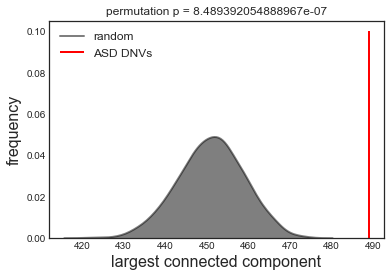

In [170]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(ASD_LCC_list),ymin=0,ymax=0.1,color='r',lw=2,label='ASD DNVs')
sns.kdeplot(ASD_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
ASD_LCC_z = (np.mean(ASD_LCC_list)-np.mean(ASD_LCC_size_rand))/np.std(ASD_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(ASD_LCC_z))

plt.title('permutation p = '+str(1-ndtr(ASD_LCC_z)))

plt.savefig('../../manuscript/figures_18_02/supplement/ASD_LCC_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

0.0


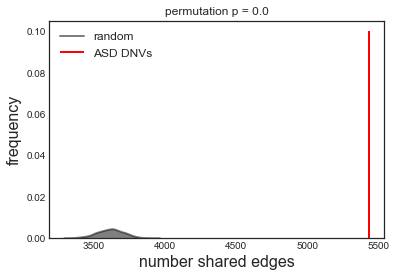

In [171]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(ASD_numedges_list),ymin=0,ymax=0.1,color='r',lw=2,label='ASD DNVs')
sns.kdeplot(ASD_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
ASD_NE_z = (np.mean(ASD_numedges_list)-np.mean(ASD_numedges_rand))/np.std(ASD_numedges_rand)

from scipy.special import ndtr
print(1-ndtr(ASD_NE_z))

plt.title('permutation p = '+str(1-ndtr(ASD_NE_z)))

plt.savefig('../../manuscript/figures_18_02/supplement/ASD_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

## CHD localization

In [172]:
heat.DEG_list = CHD_DNV
heat.DEG_list = list(np.intersect1d(heat.DEG_list,heat.DG_universe.nodes()))
print(len(heat.DEG_list))

290


In [173]:
# set numreps to 1000 for full run
num_reps=1000
CHD_numedges_list, CHD_numedges_rand, CHD_LCC_list, CHD_LCC_size_rand = heat.localization(num_reps = num_reps, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'both', 
                                                                     plot = False)

0.067549545839236
Ks_2sampResult(statistic=0.628, pvalue=1.268147821232054e-173)


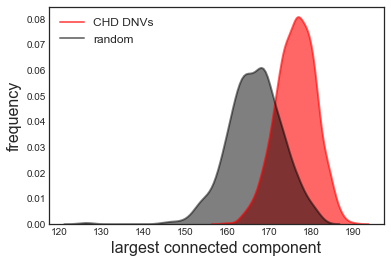

In [174]:
sns.set_style('white')
sns.kdeplot(CHD_LCC_list,color='r',lw=2,alpha=.6,shade=True,label='CHD DNVs')
sns.kdeplot(CHD_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='best',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
CHD_LCC_z = (np.mean(CHD_LCC_list)-np.mean(CHD_LCC_size_rand))/np.std(CHD_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(CHD_LCC_z))

from scipy.stats import ks_2samp
print(ks_2samp(CHD_LCC_list,CHD_LCC_size_rand))

plt.savefig('../../manuscript/figures_18_02/GIANT_p2/CHD_LCC_'+int_name+'_80_bootstrap_N'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

0.0005540293416901321
Ks_2sampResult(statistic=0.871, pvalue=0.0)


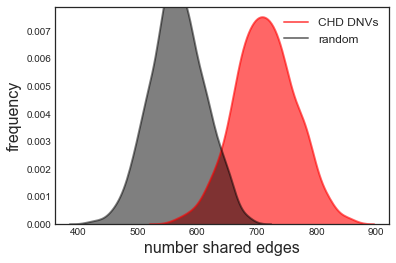

In [175]:
sns.set_style('white')
sns.kdeplot(CHD_numedges_list,color='r',lw=2,alpha=.6,shade=True,label='CHD DNVs')
sns.kdeplot(CHD_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='best',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
CHD_numedges_z = (np.mean(CHD_numedges_list)-np.mean(CHD_numedges_rand))/np.std(CHD_numedges_rand)

from scipy.special import ndtr
print(1-ndtr(CHD_numedges_z))

from scipy.stats import ks_2samp
print(ks_2samp(CHD_numedges_list,CHD_numedges_rand))

plt.savefig('../../manuscript/figures_18_02/GIANT_p2/CHD_numedges_'+int_name+'_80_bootstrap_N'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

In [176]:
# ---- non-sampled case ----
# set num_reps to 1000 for full run
num_reps=1000
CHD_numedges_list, CHD_numedges_rand, CHD_LCC_list, CHD_LCC_size_rand = heat.localization(num_reps = num_reps, 
                                                                     sample_frac = 1.0, 
                                                                     method = 'both', 
                                                                     plot = False)

0.021264447740456438


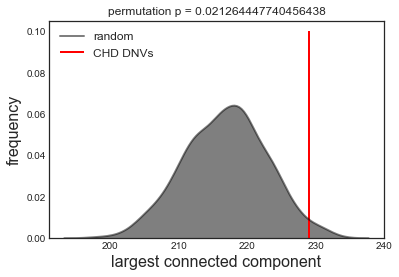

In [177]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(CHD_LCC_list),ymin=0,ymax=0.1,color='r',lw=2,label='CHD DNVs')
sns.kdeplot(CHD_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
CHD_LCC_z = (np.mean(CHD_LCC_list)-np.mean(CHD_LCC_size_rand))/np.std(CHD_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(CHD_LCC_z))

plt.title('permutation p = '+str(1-ndtr(CHD_LCC_z)))

plt.savefig('../../manuscript/figures_18_02/supplement/CHD_LCC_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

3.168576512280197e-13


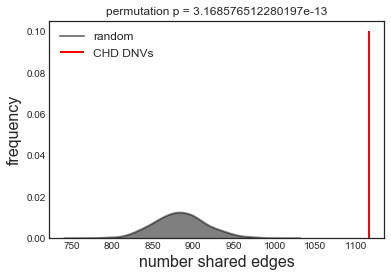

In [178]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(CHD_numedges_list),ymin=0,ymax=0.1,color='r',lw=2,label='CHD DNVs')
sns.kdeplot(CHD_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
CHD_numedges_z = (np.mean(CHD_numedges_list)-np.mean(CHD_numedges_rand))/np.std(CHD_numedges_rand)

from scipy.special import ndtr
print(1-ndtr(CHD_numedges_z))

plt.title('permutation p = '+str(1-ndtr(CHD_numedges_z)))

plt.savefig('../../manuscript/figures_18_02/supplement/CHD_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

## EPI localization

In [179]:
heat.DEG_list = EPI_full_DNV
heat.DEG_list = list(np.intersect1d(heat.DEG_list,heat.DG_universe.nodes()))
print(len(heat.DEG_list))

245


In [180]:
# set numreps to 1000 for full run
num_reps=1000
EPI_numedges_list, EPI_numedges_rand, EPI_LCC_list, EPI_LCC_size_rand = heat.localization(num_reps = num_reps, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'both', 
                                                                     plot = False)

0.11696043985362747
Ks_2sampResult(statistic=0.63, pvalue=9.959605915948879e-175)


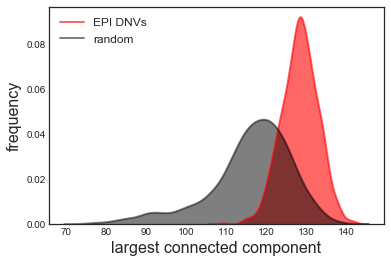

In [181]:
sns.set_style('white')
sns.kdeplot(EPI_LCC_list,color='r',lw=2,alpha=.6,shade=True,label='EPI DNVs')
sns.kdeplot(EPI_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='best',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
EPI_LCC_z = (np.mean(EPI_LCC_list)-np.mean(EPI_LCC_size_rand))/np.std(EPI_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(EPI_LCC_z))

from scipy.stats import ks_2samp
print(ks_2samp(EPI_LCC_list,EPI_LCC_size_rand))

plt.savefig('../../manuscript/figures_18_02/GIANT_p2/EPI_LCC_'+int_name+'_80_bootstrap_N'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

0.0008379265411210257
Ks_2sampResult(statistic=0.878, pvalue=0.0)


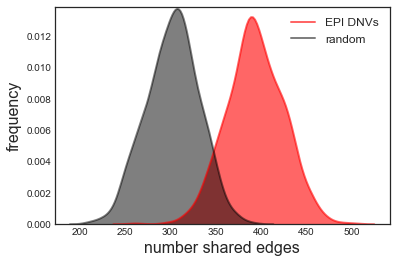

In [182]:
sns.set_style('white')
sns.kdeplot(EPI_numedges_list,color='r',lw=2,alpha=.6,shade=True,label='EPI DNVs')
sns.kdeplot(EPI_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='best',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
EPI_numedges_z = (np.mean(EPI_numedges_list)-np.mean(EPI_numedges_rand))/np.std(EPI_numedges_rand)

from scipy.special import ndtr
print(1-ndtr(EPI_numedges_z))

from scipy.stats import ks_2samp
print(ks_2samp(EPI_numedges_list,EPI_numedges_rand))

plt.savefig('../../manuscript/figures_18_02/GIANT_p2/EPI_numedges_'+int_name+'_80_bootstrap_N'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

In [183]:
# ----- non-sampled case ------
# set numreps to 1000 for full run
num_reps=1000
EPI_numedges_list, EPI_numedges_rand, EPI_LCC_list, EPI_LCC_size_rand = heat.localization(num_reps = 100, 
                                                                     sample_frac = 1.0, 
                                                                     method = 'both', 
                                                                     plot = False)

0.029690992193377674


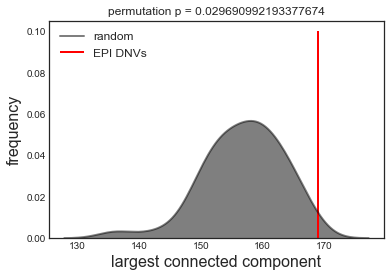

In [184]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(EPI_LCC_list),ymin=0,ymax=0.1,color='r',lw=2,label='EPI DNVs')
sns.kdeplot(EPI_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
EPI_LCC_z = (np.mean(EPI_LCC_list)-np.mean(EPI_LCC_size_rand))/np.std(EPI_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(EPI_LCC_z))

plt.title('permutation p = '+str(1-ndtr(EPI_LCC_z)))

plt.savefig('../../manuscript/figures_18_02/supplement/EPI_LCC_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

4.3044456887741944e-12


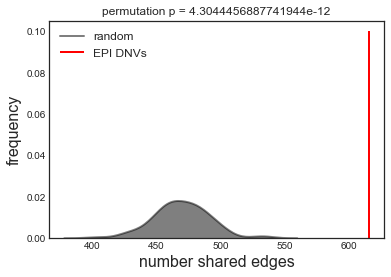

In [185]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(EPI_numedges_list),ymin=0,ymax=0.1,color='r',lw=2,label='EPI DNVs')
sns.kdeplot(EPI_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
EPI_numedges_z = (np.mean(EPI_numedges_list)-np.mean(EPI_numedges_rand))/np.std(EPI_numedges_rand)

from scipy.special import ndtr
print(1-ndtr(EPI_numedges_z))

plt.title('permutation p = '+str(1-ndtr(EPI_numedges_z)))

plt.savefig('../../manuscript/figures_18_02/supplement/EPI_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

## Control cohort localization

In [186]:
heat.DEG_list = ctrl_DNV
heat.DEG_list = list(np.intersect1d(heat.DEG_list,heat.DG_universe.nodes()))
print(len(heat.DEG_list))

156


In [187]:
# set numreps to 1000 for full run
num_reps=1000
CTRL_numedges_list, CTRL_numedges_rand, CTRL_LCC_list, CTRL_LCC_size_rand = heat.localization(num_reps = 100, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'both', 
                                                                     plot = False)

0.23290303606518203
Ks_2sampResult(statistic=0.41000000000000003, pvalue=5.2233332607580044e-08)


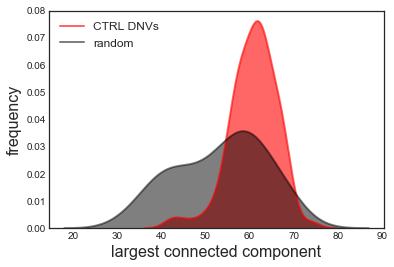

In [188]:
sns.set_style('white')
sns.kdeplot(CTRL_LCC_list,color='r',lw=2,alpha=.6,shade=True,label='CTRL DNVs')
sns.kdeplot(CTRL_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='best',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
CTRL_LCC_z = (np.mean(CTRL_LCC_list)-np.mean(CTRL_LCC_size_rand))/np.std(CTRL_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(CTRL_LCC_z))

from scipy.stats import ks_2samp
print(ks_2samp(CTRL_LCC_list,CTRL_LCC_size_rand))

plt.savefig('../../manuscript/figures_18_02/GIANT_p2/CTRL_LCC_'+int_name+'_80_bootstrap_N'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

0.3397249984475048
Ks_2sampResult(statistic=0.20000000000000007, pvalue=0.03137665215307245)


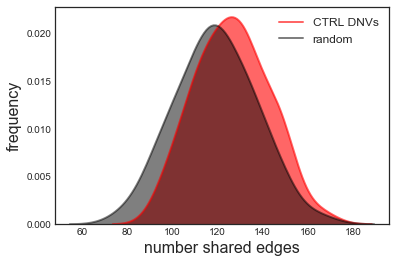

In [189]:
sns.set_style('white')
sns.kdeplot(CTRL_numedges_list,color='r',lw=2,alpha=.6,shade=True,label='CTRL DNVs')
sns.kdeplot(CTRL_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='best',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
CTRL_numedges_z = (np.mean(CTRL_numedges_list)-np.mean(CTRL_numedges_rand))/np.std(CTRL_numedges_rand)

from scipy.special import ndtr
print(1-ndtr(CTRL_numedges_z))

from scipy.stats import ks_2samp
print(ks_2samp(CTRL_numedges_list,CTRL_numedges_rand))

plt.savefig('../../manuscript/figures_18_02/GIANT_p2/CTRL_numedges_'+int_name+'_80_bootstrap_N'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

In [190]:
# set numreps to 1000 for full run
num_reps=1000
CTRL_numedges_list, CTRL_numedges_rand, CTRL_LCC_list, CTRL_LCC_size_rand = heat.localization(num_reps = 100, 
                                                                     sample_frac = 1.0, 
                                                                     method = 'both', 
                                                                     plot = False)

0.28154303883527576


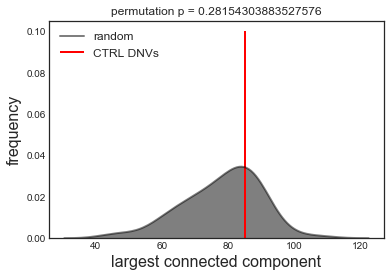

In [192]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(CTRL_LCC_list),ymin=0,ymax=0.1,color='r',lw=2,label='CTRL DNVs')
sns.kdeplot(CTRL_LCC_size_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('largest connected component',fontsize=16)

# print the z-score and fdr
CTRL_LCC_z = (np.mean(CTRL_LCC_list)-np.mean(CTRL_LCC_size_rand))/np.std(CTRL_LCC_size_rand)

from scipy.special import ndtr
print(1-ndtr(CTRL_LCC_z))

plt.title('permutation p = '+str(1-ndtr(CTRL_LCC_z)))

plt.savefig('../../manuscript/figures_18_02/supplement/CTRL_LCC_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')

0.22789014840704191


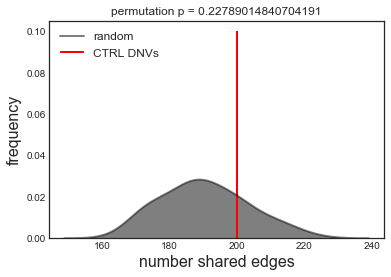

In [193]:
# plot distributions for non-sampled case
sns.set_style('white')
plt.vlines(np.mean(CTRL_numedges_list),ymin=0,ymax=0.1,color='r',lw=2,label='CTRL DNVs')
sns.kdeplot(CTRL_numedges_rand,color='k',lw=2,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=12)
plt.ylabel('frequency',fontsize=16)
plt.xlabel('number shared edges',fontsize=16)

# print the z-score and fdr
CTRL_numedges_z = (np.mean(CTRL_numedges_list)-np.mean(CTRL_numedges_rand))/np.std(CTRL_numedges_rand)

from scipy.special import ndtr
print(1-ndtr(CTRL_numedges_z))

plt.title('permutation p = '+str(1-ndtr(CTRL_numedges_z)))

plt.savefig('../../manuscript/figures_18_02/supplement/CTRL_numedges_'+int_name+'_no_bootstrap'+str(num_reps)+'.pdf',dpi=300,bbox_inches='tight')